In [3]:
from sklearn import tree
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [20]:
# CONCATENATE ALL INTO ONE TXT FILE IN BKND_TXT
# THEN READ THAT FILE IN

#cols = [0,1,3,4,5,6,7,8]

filepath = "/lustre19/expphy/volatile/clas12/users/erins/neutron-veto/d_2gev/2gev_txt/"
neutron_names = glob(filepath + "goodn_jus_pCD_015*.txt")
n_arrays = [np.genfromtxt(f, invalid_raise=False) for f in neutron_names]
ndata = np.concatenate(n_arrays, axis=0)[:,:]
# only 333 neutrons in e'p


proton_names = glob(filepath + "badn_jus_pCD_015*.txt")
p_arrays = [np.genfromtxt(f, invalid_raise=False) for f in proton_names]
pdata = np.concatenate(p_arrays, axis=0)[:,:]


ny = np.ones(len(ndata)) # neutrons - assigned 1
py = np.zeros(len(pdata)) # protons - assigned 0

print(np.shape(ndata))
print(np.shape(pdata))

myX = np.concatenate((ndata,pdata),axis=0)
myX = np.nan_to_num(myX, nan=0)
myY = np.concatenate((ny,py),axis=0)
print(np.argwhere(np.isnan(myX)))

# number of good neutrons (pCDn): 261,475
# number of bad neutrons (pCDn): 476,958
# number of good neutrons (pFDn): 8510
# number of bad neutrons (pFDn):79338
# if no theta_pmiss cut (pCDn), 3269k good neutrons
# if no theta_pmiss cut (pCDn), 1.05M good neutrons

(95742, 8)
(378055, 8)
[]


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    myX,
    myY,
    shuffle=True,
    test_size=0.6,
)

from sklearn.preprocessing import StandardScaler

"""sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)"""

clf = GradientBoostingClassifier(learning_rate=0.2, max_depth=5, verbose=1)
#clf = RandomForestClassifier(max_depth=5, random_state=0)

clf.fit(X_train,y_train)

print("Accuracy:")
print(clf.score(X_train,y_train))
print(clf.score(X_test,y_test))

      Iter       Train Loss   Remaining Time 
         1           0.8977           39.61s
         2           0.8330           39.35s
         3           0.7890           39.19s
         4           0.7575           38.83s
         5           0.7337           38.26s
         6           0.7157           37.66s
         7           0.7019           37.27s
         8           0.6913           36.88s
         9           0.6828           36.41s
        10           0.6759           35.93s
        20           0.6497           31.95s
        30           0.6443           28.15s
        40           0.6416           24.30s
        50           0.6389           20.35s
        60           0.6368           16.34s
        70           0.6348           12.26s
        80           0.6331            8.18s
        90           0.6311            4.10s
       100           0.6292            0.00s
Accuracy:
0.8329973933874355
0.822737521941473


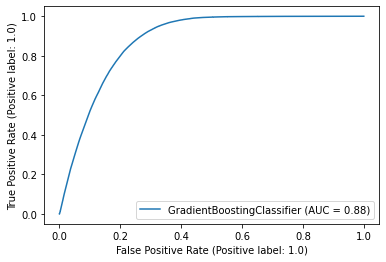

In [22]:
# ROC curve? illustrate tree application somehow
metrics.plot_roc_curve(clf, X_test, y_test)
plt.savefig("d2_accuracy.png")
# plot of accuracy or something

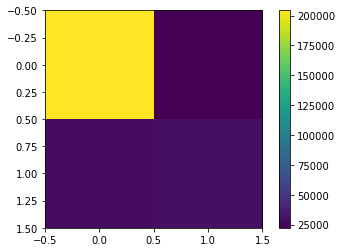

In [23]:
# confusion matrix
y_pred_test = clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred_test)
plt.imshow(mat)
plt.colorbar()

In [24]:
import pandas as pd
#feature_list = ['num recon n','is_CND1 (bool)','is_CND2 (bool)','is_CND3 (bool)','num layers',
#                'num CND hits (event)','num CND ADCs (event)','num CND TDCs (event)',
#                'num CTOF ADCs (event)','num CTOF TDCs (event)','num CND clusters','pindex',
#                'sector','layer','component','energy','path','num CTOF hits','CTOF energy',
#                '4NN','corners','8NN','time','status','dedx','size','CTOF hit match',
#                'CTOF event energy','eN_angle','x','y','z']
feature_list = [#'layer',
                'neutron energy',
                'CND layer multiplicity',#'z',
                'cluster size',#'beta',
                'CND nearby hits',
                'CND nearby energy',
                'CTOF nearby energy','CTOF nearby hits',
                'angle diff CVT 12'
                ]
d = {'feature': feature_list, 'importance': clf.feature_importances_}
df = pd.DataFrame(data=d)
df.sort_values(by='importance', ascending=False)

,feature,importance
7,angle diff CVT 12,0.564914
6,CTOF nearby hits,0.235744
3,CND nearby hits,0.102415
0,neutron energy,0.038285
5,CTOF nearby energy,0.020502
4,CND nearby energy,0.019123
1,CND layer multiplicity,0.018101
2,cluster size,0.000915


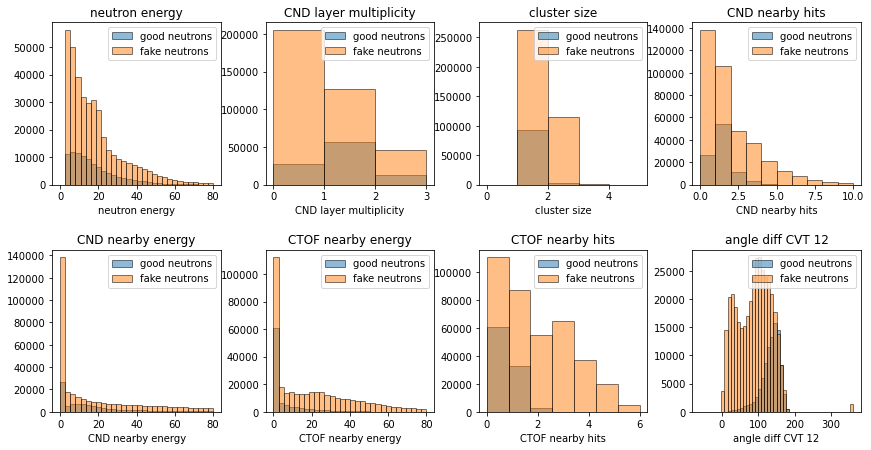

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
fig.subplots_adjust(hspace=0.4)
"""for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.xlabel(feature_list[i])
    plt.title(feature_list[i])"""

highE = 80

plt.subplot(2,4,1)
plt.hist(ndata[:,0],bins=30,range=(0,highE),alpha=0.5,edgecolor="black",label="good neutrons")
plt.hist(pdata[:,0],bins=30,range=(0,highE),alpha=0.5,edgecolor="black",label="fake neutrons")
plt.xlabel(feature_list[0])
plt.title(feature_list[0])
plt.legend()
plt.subplot(2,4,2)
plt.hist(ndata[:,1],bins=3,range=(0,3),alpha=0.5,edgecolor="black",label="good neutrons")
plt.hist(pdata[:,1],bins=3,range=(0,3),alpha=0.5,edgecolor="black",label="fake neutrons")
plt.xlabel(feature_list[1])
plt.title(feature_list[1])
plt.legend()
plt.subplot(2,4,3)
plt.hist(ndata[:,2],bins=5,range=(0,5),alpha=0.5,edgecolor="black",label="good neutrons")
plt.hist(pdata[:,2],bins=5,range=(0,5),alpha=0.5,edgecolor="black",label="fake neutrons")
plt.xlabel(feature_list[2])
plt.title(feature_list[2])
plt.legend()
plt.subplot(2,4,4)
plt.hist(ndata[:,3],bins=10,range=(0,10),alpha=0.5,edgecolor="black",label="good neutrons")
plt.hist(pdata[:,3],bins=10,range=(0,10),alpha=0.5,edgecolor="black",label="fake neutrons")
plt.xlabel(feature_list[3])
plt.title(feature_list[3])
plt.legend()
plt.subplot(2,4,5)
plt.hist(ndata[:,4],bins=30,range=(0,highE),alpha=0.5,edgecolor="black",label="good neutrons")
plt.hist(pdata[:,4],bins=30,range=(0,highE),alpha=0.5,edgecolor="black",label="fake neutrons")
plt.xlabel(feature_list[4])
plt.title(feature_list[4])
plt.legend()
plt.subplot(2,4,6)
plt.hist(ndata[:,5],bins=30,range=(0,highE),alpha=0.5,edgecolor="black",label="good neutrons")
plt.hist(pdata[:,5],bins=30,range=(0,highE),alpha=0.5,edgecolor="black",label="fake neutrons")
plt.xlabel(feature_list[5])
plt.title(feature_list[5])
plt.legend()
plt.subplot(2,4,7)
plt.hist(ndata[:,6],bins=7,range=(0,6),alpha=0.5,edgecolor="black",label="good neutrons")
plt.hist(pdata[:,6],bins=7,range=(0,6),alpha=0.5,edgecolor="black",label="fake neutrons")
plt.xlabel(feature_list[6])
plt.title(feature_list[6])
plt.legend()
plt.subplot(2,4,8)
plt.hist(ndata[:,7],bins=50,range=(-60,360),alpha=0.5,edgecolor="black",label="good neutrons")
plt.hist(pdata[:,7],bins=50,range=(-60,360),alpha=0.5,edgecolor="black",label="fake neutrons")
plt.xlabel(feature_list[7])
plt.title(feature_list[7])
plt.legend()


#plt.subplot(2,4,8)
#plt.axis("off")

plt.savefig("d2_features.png")

# TEST ON SIMULATION

In [26]:
filepath = "/w/hallb-scshelf2102/clas/clase2/erins/repos/neutron-veto/Simulation_eN/"
sim_neutron_names = glob(filepath + "eN_bknd/bknd_txt/good_neutrons_*.txt")
sim_n_arrays = [np.genfromtxt(f, invalid_raise=False) for f in sim_neutron_names]
sim_ndata = np.concatenate(sim_n_arrays, axis=0)[0:274000,:]
# only 333 neutrons in e'p


sim_proton_names = glob(filepath + "eN_bknd/bknd_txt/fake_neutrons_*.txt")
sim_p_arrays = [np.genfromtxt(f, invalid_raise=False) for f in sim_proton_names]
sim_pdata = np.concatenate(sim_p_arrays, axis=0)[0:274000,:]

sim_ny = np.zeros(len(sim_ndata)) # neutrons - assigned 0
sim_py = np.ones(len(sim_pdata)) # protons - assigned 1

print(np.shape(sim_ndata))
print(np.shape(sim_pdata))

sim_myX = np.concatenate((sim_ndata,sim_pdata),axis=0)
sim_myX = np.nan_to_num(sim_myX, nan=0)
sim_myY = np.concatenate((sim_ny,sim_py),axis=0)

print(clf.score(sim_myX,sim_myY))

(34059, 8)
(38036, 8)
0.45567653790138013


# TEST ON pFD

In [31]:
filepath = "/lustre19/expphy/volatile/clas12/users/erins/neutron-veto/d_2gev2gev_txt/"
fd_neutron_names = glob(filepath + "goodn_jus_pFD_015*.txt")
fd_n_arrays = [np.genfromtxt(f, invalid_raise=False) for f in fd_neutron_names]
fd_ndata = np.concatenate(fd_n_arrays, axis=0)[0:274000,:]
# only 333 neutrons in e'p


fd_proton_names = glob(filepath + "badn_jus_pFD_015*.txt")
fd_p_arrays = [np.genfromtxt(f, invalid_raise=False) for f in fd_proton_names]
fd_pdata = np.concatenate(fd_p_arrays, axis=0)[0:274000,:]

fd_ny = np.zeros(len(fd_ndata)) # neutrons - assigned 0
fd_py = np.ones(len(fd_pdata)) # protons - assigned 1

print(np.shape(fd_ndata))
print(np.shape(fd_pdata))

fd_myX = np.concatenate((fd_ndata,fd_pdata),axis=0)
fd_myX = np.nan_to_num(fd_myX, nan=0)
fd_myY = np.concatenate((fd_ny,fd_py),axis=0)

print(clf.score(fd_myX,fd_myY))

ValueError: need at least one array to concatenate

# Test on 6 GeV

In [29]:
filepath = "/w/hallb-scshelf2102/clas/clase2/erins/repos/neutron-veto/d_6gev/6gev_txt/"
fd_neutron_names = glob(filepath + "goodn_jus_pCD_015*.txt")
fd_n_arrays = [np.genfromtxt(f, invalid_raise=False) for f in fd_neutron_names]
fd_ndata = np.concatenate(fd_n_arrays, axis=0)[0:274000,:]
# only 333 neutrons in e'p


fd_proton_names = glob(filepath + "badn_jus_pCD_015*.txt")
fd_p_arrays = [np.genfromtxt(f, invalid_raise=False) for f in fd_proton_names]
fd_pdata = np.concatenate(fd_p_arrays, axis=0)[0:274000,:]

fd_ny = np.zeros(len(fd_ndata)) # neutrons - assigned 0
fd_py = np.ones(len(fd_pdata)) # protons - assigned 1

print(np.shape(fd_ndata))
print(np.shape(fd_pdata))

fd_myX = np.concatenate((fd_ndata,fd_pdata),axis=0)
fd_myX = np.nan_to_num(fd_myX, nan=0)
fd_myY = np.concatenate((fd_ny,fd_py),axis=0)

print(clf.score(fd_myX,fd_myY))

(4155, 8)
(1500, 8)
0.7372236958443855
